In [1]:
import sys
sys.path.append('../')

In [10]:
## LARYNGEAL TISSUE DATASET

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from keras import backend as K
from keras.models import load_model
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from importlib import reload
import libs.analysis as analysis
import libs.cnn_model as cnn_model

In [46]:
# reloads 
reload(cnn_model)

<module 'libs.cnn_model' from '../libs/cnn_model.py'>

In [13]:
# Data Preparation
import glob
import cv2
import os

# 0 = He, 1 = Le, 2 = IPCL, 3 = Hbv
labels = [0,1,2,3]
patch_size = 101

# He = healthy
# Le = Leukoplakia
# IPCL = intraepithelial papillary capillarry loops
# Hbv = hypertrophic blood vessels
he = glob.glob('./datasets/laryngeal_dataset/*/He/*.png')
le = glob.glob('./datasets/laryngeal_dataset/*/Le/*.png')
ipcl = glob.glob('./datasets/laryngeal_dataset/*/IPCL/*.png')
hbv = glob.glob('./datasets/laryngeal_dataset/*/Hbv/*.png')

def read_data(data, label_id, patch_size):
    size = len(data)
    images = np.zeros((size, patch_size, patch_size, 3), dtype=np.float32)
    labels = np.zeros(size, dtype=np.int64)
    target_shape = (patch_size, patch_size, 3)
    
    for idx in range(size):
        img = cv2.imread(os.path.join(data[idx]))
        if img.shape != target_shape:
            print('resizing image from {} to {}'.format(img.shape, target_shape))
            img = cv2.resize(img, (target_shape[0], target_shape[1]))
        images[idx] = img
        labels[idx] = label_id
        
    return images, labels

he_images, he_labels = read_data(he, 0, patch_size)
le_images, le_labels = read_data(le, 1, patch_size)
ipcl_images, ipcl_labels = read_data(ipcl, 2, patch_size)
hbv_images, hbv_labels = read_data(hbv, 3, patch_size)

resizing image from (100, 101, 3) to (101, 101, 3)
resizing image from (102, 102, 3) to (101, 101, 3)
resizing image from (102, 102, 3) to (101, 101, 3)
resizing image from (102, 102, 3) to (101, 101, 3)
resizing image from (102, 102, 3) to (101, 101, 3)
resizing image from (102, 102, 3) to (101, 101, 3)
resizing image from (102, 102, 3) to (101, 101, 3)
resizing image from (101, 98, 3) to (101, 101, 3)
resizing image from (102, 102, 3) to (101, 101, 3)
resizing image from (102, 102, 3) to (101, 101, 3)
resizing image from (102, 102, 3) to (101, 101, 3)
resizing image from (102, 102, 3) to (101, 101, 3)
resizing image from (102, 102, 3) to (101, 101, 3)
resizing image from (102, 102, 3) to (101, 101, 3)
resizing image from (102, 102, 3) to (101, 101, 3)
resizing image from (102, 102, 3) to (101, 101, 3)
resizing image from (102, 102, 3) to (101, 101, 3)
resizing image from (102, 102, 3) to (101, 101, 3)
resizing image from (102, 102, 3) to (101, 101, 3)
resizing image from (102, 102, 3

In [14]:
print(he_images.shape)
print(le_images.shape)
print(ipcl_images.shape)
print(hbv_images.shape)
from sklearn.model_selection import train_test_split

# merge the images and labels
x_data = np.concatenate((he_images, le_images, ipcl_images, hbv_images), axis=0)
y_data = np.concatenate((he_labels, le_labels, ipcl_labels, hbv_labels), axis=0)
print(x_data.shape, y_data.shape)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state=42)

(330, 101, 101, 3)
(330, 101, 101, 3)
(330, 101, 101, 3)
(330, 101, 101, 3)
(1320, 101, 101, 3) (1320,)


In [15]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(990, 101, 101, 3)
(990,)
(330, 101, 101, 3)
(330,)


In [16]:
# Parameters
batch_size = 64
epochs = 15
num_classes = 4

img_rows, img_cols = (101, 101)

# Model Destination
model_dest_file = 'laryng_cnn_model2.h5'

In [17]:
# Data normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_val = x_val.astype('float32')

train_mean = np.mean(x_train)
train_std  = np.std(x_train)


x_train = (x_train - train_mean) / (train_std + 1e-7)
x_test = (x_test - train_mean) / (train_std + 1e-7)


#x_train /= 255
#x_test /= 255
#x_val /= 255

In [9]:
# reshape the data
#x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
#x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
#x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)

print(x_train.shape)
print(x_test.shape)
#print(x_val.shape)

(990, 101, 101, 3)
(330, 101, 101, 3)


In [18]:
# Convert classes to one-hot encoding
num_classes = 4
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
#y_val = keras.utils.to_categorical(y_val, num_classes)

In [ ]:
# if we're loading a model load it!
model = load_model(model_dest_file)

In [19]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), strides=2, padding = 'same', input_shape = (101,101,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(3,3)))
model.add(Activation('relu'))
model.add(Conv2D(filters = 192, kernel_size = (4,4), padding = 'Same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(3,3)))
#model.add(Dropout(0.25))

model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'Same'))
model.add(Activation('relu'))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'Same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dense(4096))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 51, 51, 64)        4864      
_________________________________________________________________
activation_1 (Activation)    (None, 51, 51, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
activation_2 (Activation)    (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 192)       196800    
_________________________________________________________________
activation_3 (Activation)    (None, 17, 17, 192)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 192)         0         
__________

In [20]:
# Define the optimizer
learning_rate = 0.1e-4
decay = 1e-6

optimizer = RMSprop(lr=learning_rate, decay=0.0)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

In [25]:
batch_size = 64

# increase the epochs to tune up the accuracy of the model
epochs = 10

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=35,                    # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                     # Randomly zoom image 
        width_shift_range=0.15,                # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,               # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,                 # randomly flip images
        vertical_flip=False)                   # randomly flip images


datagen.fit(x_train)


# Fit i.e. train the model
#history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
#                      verbose=1, validation_data=(x_test, y_test))

history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              workers = 8,
                              verbose = 1, steps_per_epoch = x_train.shape[0] # batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/10
990/990 [==============================] - 85s 86ms/step - loss: 0.3154 - acc: 0.8509 - val_loss: 0.3261 - val_acc: 0.8485
Epoch 2/10
990/990 [==============================] - 85s 86ms/step - loss: 0.2580 - acc: 0.8841 - val_loss: 0.2439 - val_acc: 0.8879
Epoch 3/10
990/990 [==============================] - 85s 86ms/step - loss: 0.2101 - acc: 0.9095 - val_loss: 0.3081 - val_acc: 0.8909
Epoch 4/10
990/990 [==============================] - 85s 86ms/step - loss: 0.1746 - acc: 0.9266 - val_loss: 0.2026 - val_acc: 0.9091
Epoch 5/10
990/990 [==============================] - 85s 86ms/step - loss: 0.1475 - acc: 0.9420 - val_loss: 0.1750 - val_acc: 0.9091
Epoch 6/10
990/990 [==============================] - 85s 86ms/step - loss: 0.1254 - acc: 0.9493 - val_loss: 0.2585 - val_acc: 0.8909
Epoch 7/10
990/990 [==============================] - 85s 86ms/step - loss: 0.1084 - acc: 0.9574 - val_loss: 0.2298 - val_acc: 0.9273
Epoch 8/10
990/990 [==============================] - 85s 85ms

In [27]:
# Save the model data
model.save(model_dest_file)

In [26]:
# Now Let's evaluate the model
score = model.evaluate(x_test, y_test, verbose=0)

In [28]:
# View the Final Loss and Accuracy scores across all epochs
analysis.print_loss_and_accuracy_from_score(score)

Test loss: 0.14745242713075696
Test accuracy: 0.957575756853277


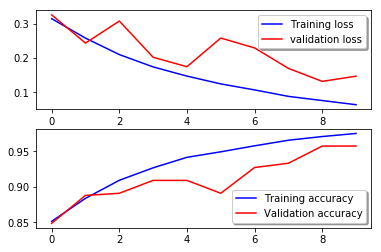

In [29]:
# View the Loss and Accuracy curves across the epochs
analysis.plot_loss_and_accuracy_curves(history, save=True)

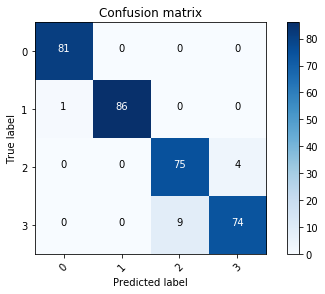

In [30]:
reload(analysis)
y_pred = model.predict(x_test)
analysis.plot_confusion_matrix(y_test, y_pred, classes=range(4), save=True)

In [34]:
reload(analysis)
scores = analysis.get_scores_oh(y_test, y_pred)
analysis.print_scores(scores)

Precision (specificity): 95.734%
Recall (sensitivity): 95.736%
Accuracy: 95.758%
F1: 95.690%
